In [1]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc
import numpy as np
import pandas as pd
import scvi
import random # we don't fix seed here so can use to re sample test patients

Global seed set to 0


In [2]:
import seaborn as sns

In [3]:
# if want to change global seed to sth else
seed = 0
from scvi._settings import settings
settings.seed = seed

Global seed set to 0


In [4]:
sc.set_figure_params(dpi=100, frameon=False)

# Read data

In [5]:
# adt.h5ad is full dataset, change to adt_test.h5ad for a smaller subset
adt = sc.read('data/haniffa-2021/adt.h5ad')
adt

AnnData object with n_obs × n_vars = 624325 × 192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch'
    var: 'feature_types'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [6]:
# rna.h5ad is full dataset, change to rna_test.h5ad for a smaller subset
rna = sc.read('data/haniffa-2021/rna.h5ad')
rna

AnnData object with n_obs × n_vars = 624325 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [7]:
# rna = rna[:, rna.var.index[:2000]]

In [8]:
idx = adt.obs['patient_id'].sort_values().index # need to sort by patient for the data loader

In [9]:
adt = adt[idx].copy()
rna = rna[idx].copy()

# MIL

In [10]:
# arange modality adatas into one adata
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [adt]],
    groups = [[0], [0]],
    layers = [['count'], [None]],
)
adata

AnnData object with n_obs × n_vars = 624325 × 4192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'batch', 'group'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'count'

In [11]:
# if want to leave out patients as test uncomment the next two cells
number_of_test_patients = 15
patients = list(adata.obs['patient_id'].cat.categories)
# test_patient_ids = random.sample(patients, number_of_test_patients)
test_patient_ids = ['CV0137',
 'MH9143271',
 'CV0068',
 'CV0201',
 'newcastle65',
 'CV0050',
 'MH9143371',
 'CV0176',
 'MH9143275',
 'MH9179825',
 'MH9143326',
 'CV0073',
 'CV0257',
 'newcastle21',
 'AP12']

adata[adata.obs.patient_id.isin(test_patient_ids)].obs[['Status_on_day_collection_summary', 'patient_id']].drop_duplicates().groupby('Status_on_day_collection_summary').count() # check class distribution for test set

,patient_id
Status_on_day_collection_summary,
Asymptomatic,1
Critical,3
Healthy,1
Mild,3
Moderate,6
Severe,1


In [12]:
# subset
adata_test = adata[adata.obs.patient_id.isin(test_patient_ids)].copy()
adata = adata[~adata.obs.patient_id.isin(test_patient_ids)].copy()

In [13]:
mtg.model.MultiVAE_MIL.setup_anndata(
            adata, 
            class_label="Status_on_day_collection_summary",
            rna_indices_end=4000,
            categorical_covariate_keys=['Sex', 'Age_interval', 'patient_id',"Smoker"],
            continuous_covariate_keys=None,)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 536388 cells, 4192 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 5 extra categorical covariates   
         and 1 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [14]:
mil = mtg.model.MultiVAE_MIL(
            adata, 
            modality_lengths=[4000, 192],
            losses=['nb', 'mse'],
            loss_coefs={'kl': 0.0001, 'integ': 0},
            class_label='Status_on_day_collection_summary',
            patient_label='patient_id',
            scoring='gated_attn', # or 'attn'
            class_layers=2,
            add_patient_to_classifier=False, # whether to use patient embeddings for classification
            hierarchical_attn=True, # whether to have hierarchical attention or just cell attention,

        )

/home/mo/miniconda3/envs/multigrate/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [ ]:
mil.train(max_epochs=150, 
    batch_size=256, n_epochs_kl_warmup=50)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/150:   1%|          | 1/150 [00:31<1:17:01, 31.02s/it, loss=757, v_num=1]

Metric elbo_validation improved. New best score: 709.039


Epoch 2/150:   1%|▏         | 2/150 [01:03<1:18:37, 31.87s/it, loss=607, v_num=1]

Metric elbo_validation improved by 113.327 >= min_delta = 0.0. New best score: 595.713


Epoch 3/150:   2%|▏         | 3/150 [01:38<1:20:46, 32.97s/it, loss=602, v_num=1]

Metric elbo_validation improved by 30.135 >= min_delta = 0.0. New best score: 565.578


Epoch 4/150:   2%|▏         | 3/150 [01:39<1:20:46, 32.97s/it, loss=602, v_num=1]

In [ ]:
# save the model

In [ ]:
mil.save("ref_hanifa_4k_w_hirarchy")

In [ ]:
mil_out = mil.get_latent_representation(batch_size=256)
latent, cell_attn, cov_attn, _ = mil_out

In [ ]:
adata.obsm['latent'] = latent
adata.obs['cell_attn'] = cell_attn

In [ ]:
# subsmaple the data for visualizaion 

In [ ]:
adata_ss = sc.pp.subsample(adata, fraction=0.05, copy=True)

In [ ]:
sc.pp.neighbors(adata_ss, use_rep='latent')
sc.tl.umap(adata_ss)

In [ ]:
sc.pl.umap(adata_ss, color=['initial_clustering',]
           ,add_outline=True, title="Cell type")

In [ ]:
sc.pl.umap(adata_ss, color=['cell_attn'], vmax=.1,title="Attention score")

In [ ]:
adata.obs.cell_attn = list(adata.obs.cell_attn)

In [ ]:
df = adata.obs[["initial_clustering","Status_on_day_collection_summary","cell_attn"]]
# df = df.pivot_table(index='Status_on_day_collection_summary', columns='initial_clustering',values='cell_attn')

In [ ]:
df_gp = df.groupby("initial_clustering")

In [ ]:
df_mean = df_gp.mean()
df_mean.reset_index(level=0, inplace=True)

In [ ]:
df_mean = df_mean.sort_values("cell_attn", ascending=False)

In [ ]:
df_mean

In [ ]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
ax=  sns.barplot(x="initial_clustering", y="cell_attn", 
                 data=df_mean, color="#1572A1", order=list(df_mean["initial_clustering"]))
fig = ax.get_figure()
plt.ylabel("Attention socre")
plt.xlabel("Cell type")
fig.savefig("./figures/att_hanifa_ct.pdf")

In [116]:
GO_0034340 = pd.read_csv("./metadata/GO_0034340.txt")
GO_0034340 =  GO_0034340.to_numpy().flatten()

biger_list = pd.read_csv('./metadata/QuickGO-annotations-1643020023245-20220124.tsv', sep='\t')
biger_list = list(biger_list["SYMBOL"])

In [118]:
# df_mean = df.groupby(["initial_clustering","Status_on_day_collection_summary"]).mean().reset_index()
df_mean = df.groupby(["initial_clustering"]).mean().reset_index()

In [119]:
top_att = df_mean[df_mean["cell_attn"] >= df_mean["cell_attn"].median()]

In [120]:
top_att= top_att.sort_values("cell_attn", ascending=False)["initial_clustering"].to_list()

In [121]:
top_att

['Mono_prolif',
 'Plasmablast',
 'MAIT',
 'CD14',
 'gdT',
 'RBC',
 'CD16',
 'Treg',
 'CD4']

In [122]:
bot_att = df_mean[df_mean["cell_attn"] < df_mean["cell_attn"].median()]
bot_att = bot_att.sort_values("cell_attn", ascending=True)["initial_clustering"].to_list()

In [123]:
bot_att

['NK_16hi',
 'HSC',
 'pDC',
 'B_cell',
 'Lymph_prolif',
 'NK_56hi',
 'Platelets',
 'CD8',
 'DCs']

### Gene score analysis om the full data

In [47]:
adata_origi = sc.read("./data/haniffa21.processed.h5ad")

In [48]:
adata_origi = adata_origi[~adata_origi.obs.Status_on_day_collection_summary.isin(["Non_covid","LPS_90mins","LPS_10hours"])]

In [166]:
sc.tl.score_genes(adata_origi,GO_0034340,)
sc.tl.score_genes(adata_origi,biger_list, score_name="biger_list")

In [167]:
df_full = adata_origi.obs[["initial_clustering","Status_on_day_collection_summary","score","biger_list"]]


In [168]:
df_mean_full = df_full.groupby(["initial_clustering","Status_on_day_collection_summary"]).mean().reset_index()

In [169]:
# df_mean_full_ss = df_mean_full[df_mean_full.initial_clustering.isin(np.unique(top_att))]

In [170]:
df_mean_full_ss = df_mean_full[df_mean_full.initial_clustering.isin(np.unique(adata.obs.initial_clustering))]

In [171]:
df_mean_full_ss.initial_clustering = df_mean_full_ss.initial_clustering.cat.remove_unused_categories()

Computing LFC socres

In [172]:
order = ["Healthy", "Asymptomatic", "Mild", "Moderate", "Severe", "Critical"]

In [173]:
heatlhy_df = df_mean_full_ss[df_mean_full_ss.Status_on_day_collection_summary == "Healthy"]
non_heatlhy_df = df_mean_full_ss[df_mean_full_ss.Status_on_day_collection_summary != "Healthy"]


In [174]:
for index, row in non_heatlhy_df.iterrows():
       ctrl = heatlhy_df[heatlhy_df.initial_clustering == f"{row['initial_clustering']}"]["score"]
       non_heatlhy_df.loc[index]["score"] = np.log2(row['score']) - np.log2(ctrl)
for index, row in non_heatlhy_df.iterrows():
    ctrl = heatlhy_df[heatlhy_df.initial_clustering == f"{row['initial_clustering']}"]["biger_list"]
    non_heatlhy_df.loc[index]["biger_list"] = np.log2(row['biger_list']) - np.log2(ctrl)

/home/mo/miniconda3/envs/multigrate/lib/python3.8/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/home/mo/miniconda3/envs/multigrate/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scoring using  smaller list from https://www.gsea-msigdb.org/gsea/msigdb/cards/GOBP_RESPONSE_TO_TYPE_I_INTERFERON.html

## averaging score over all condition to compute on score for each celltype

In [199]:
overal = non_heatlhy_df.groupby("initial_clustering").mean()
overal = overal.reset_index()

In [ ]:
overal = overal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


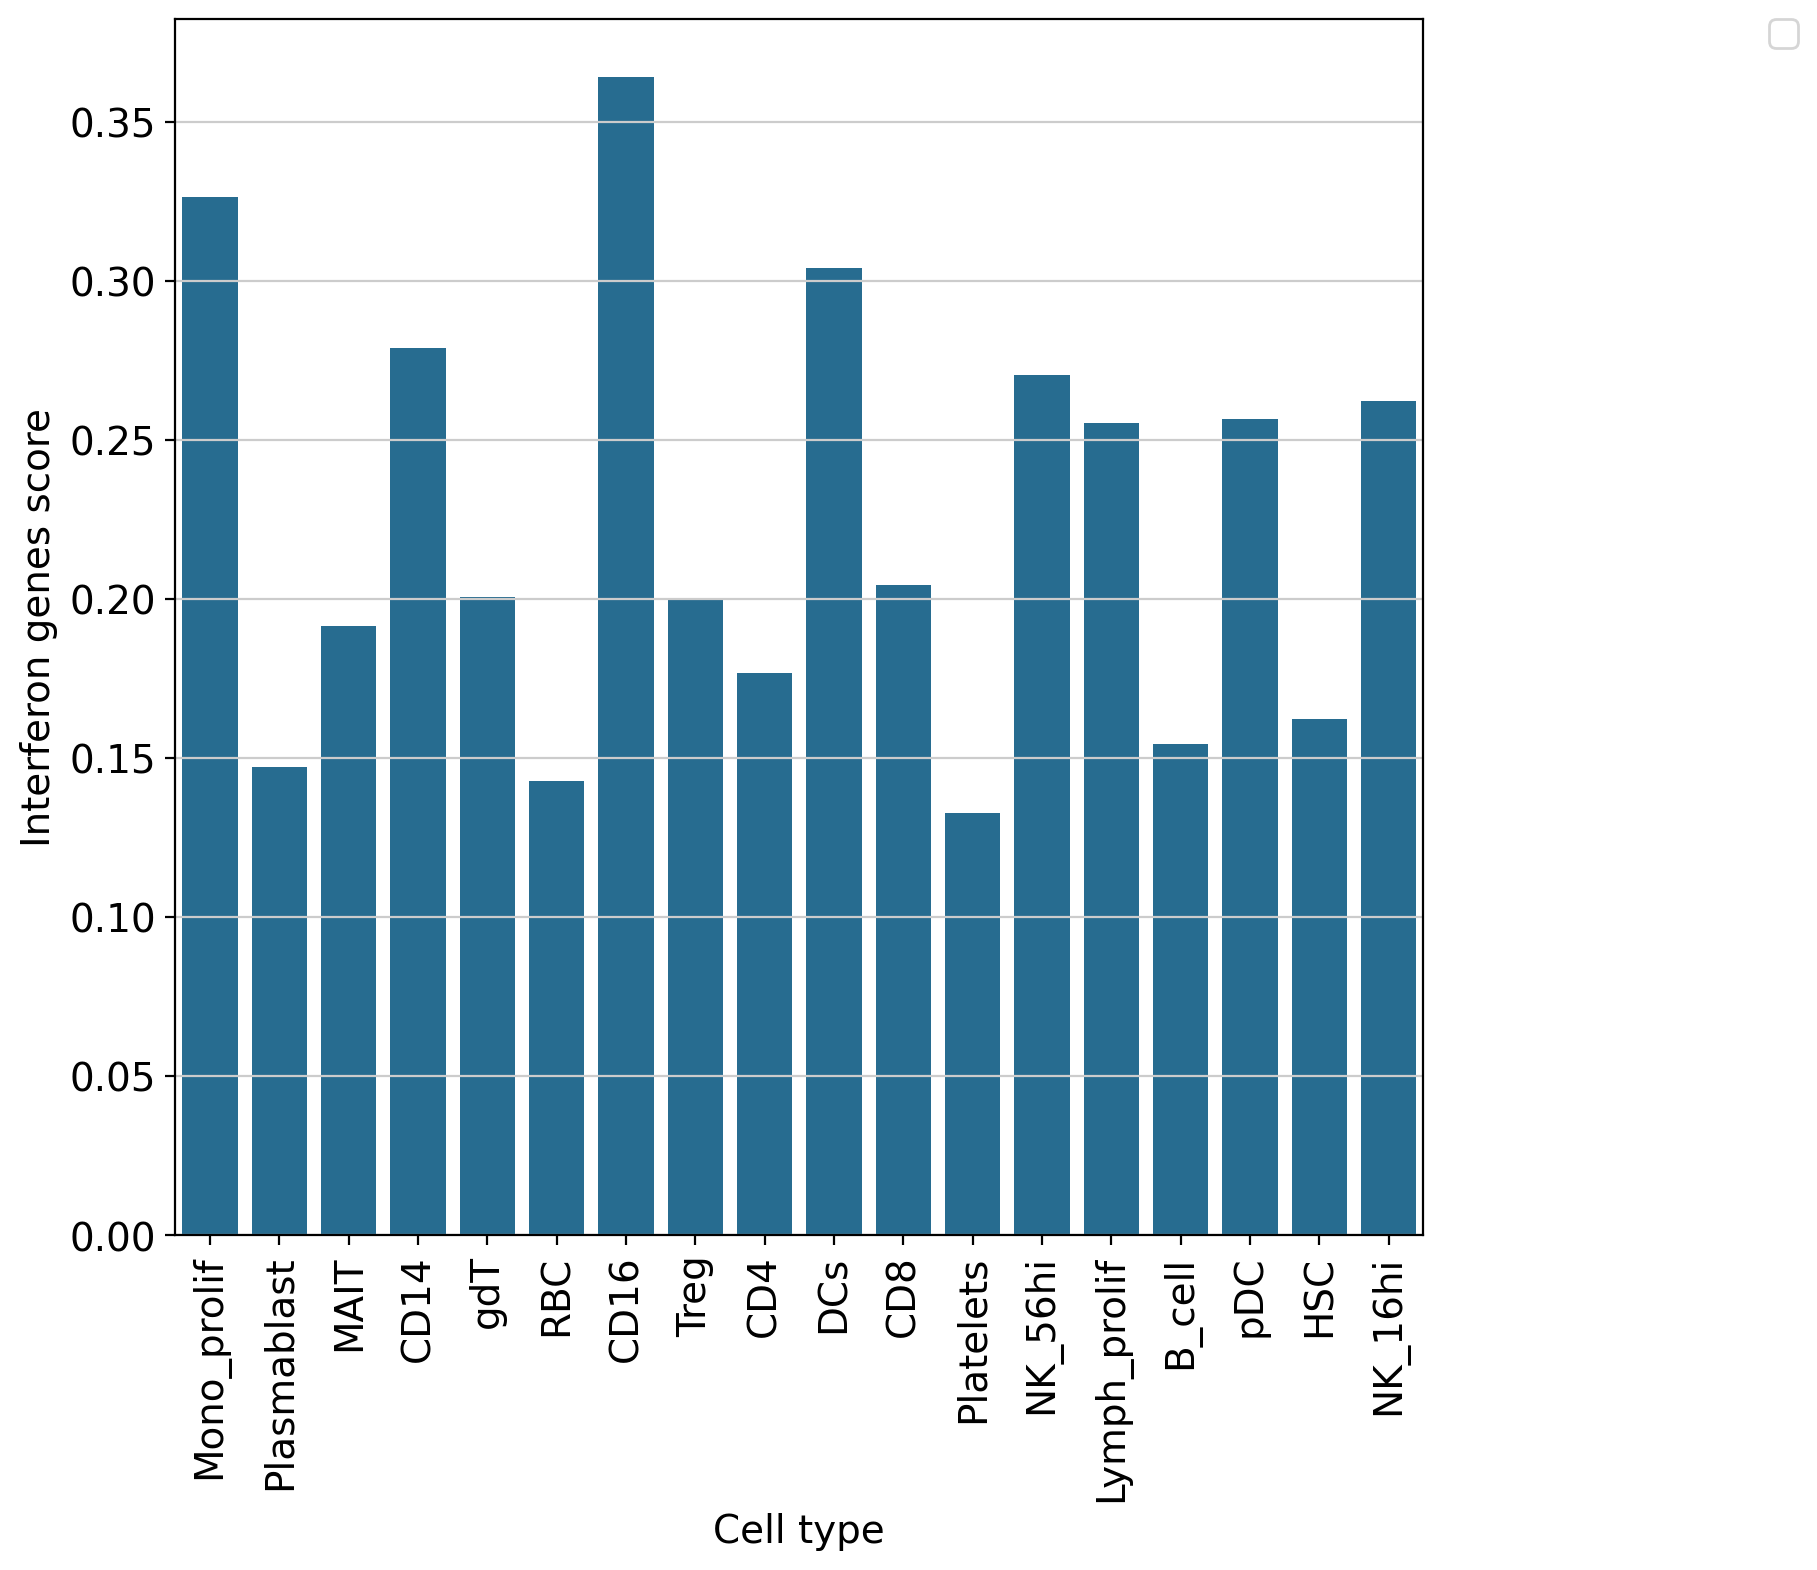

In [211]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
sns.barplot(x="initial_clustering", y="score",
            data= overal,
            hue_order=order, color="#1572A1", order=list(df_mean["initial_clustering"]))
plt.ylabel("Interferon genes score")
plt.xlabel("Cell type")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0)
fig = ax.get_figure()
fig.savefig("./figures/att_hanifa_ct_lfc.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


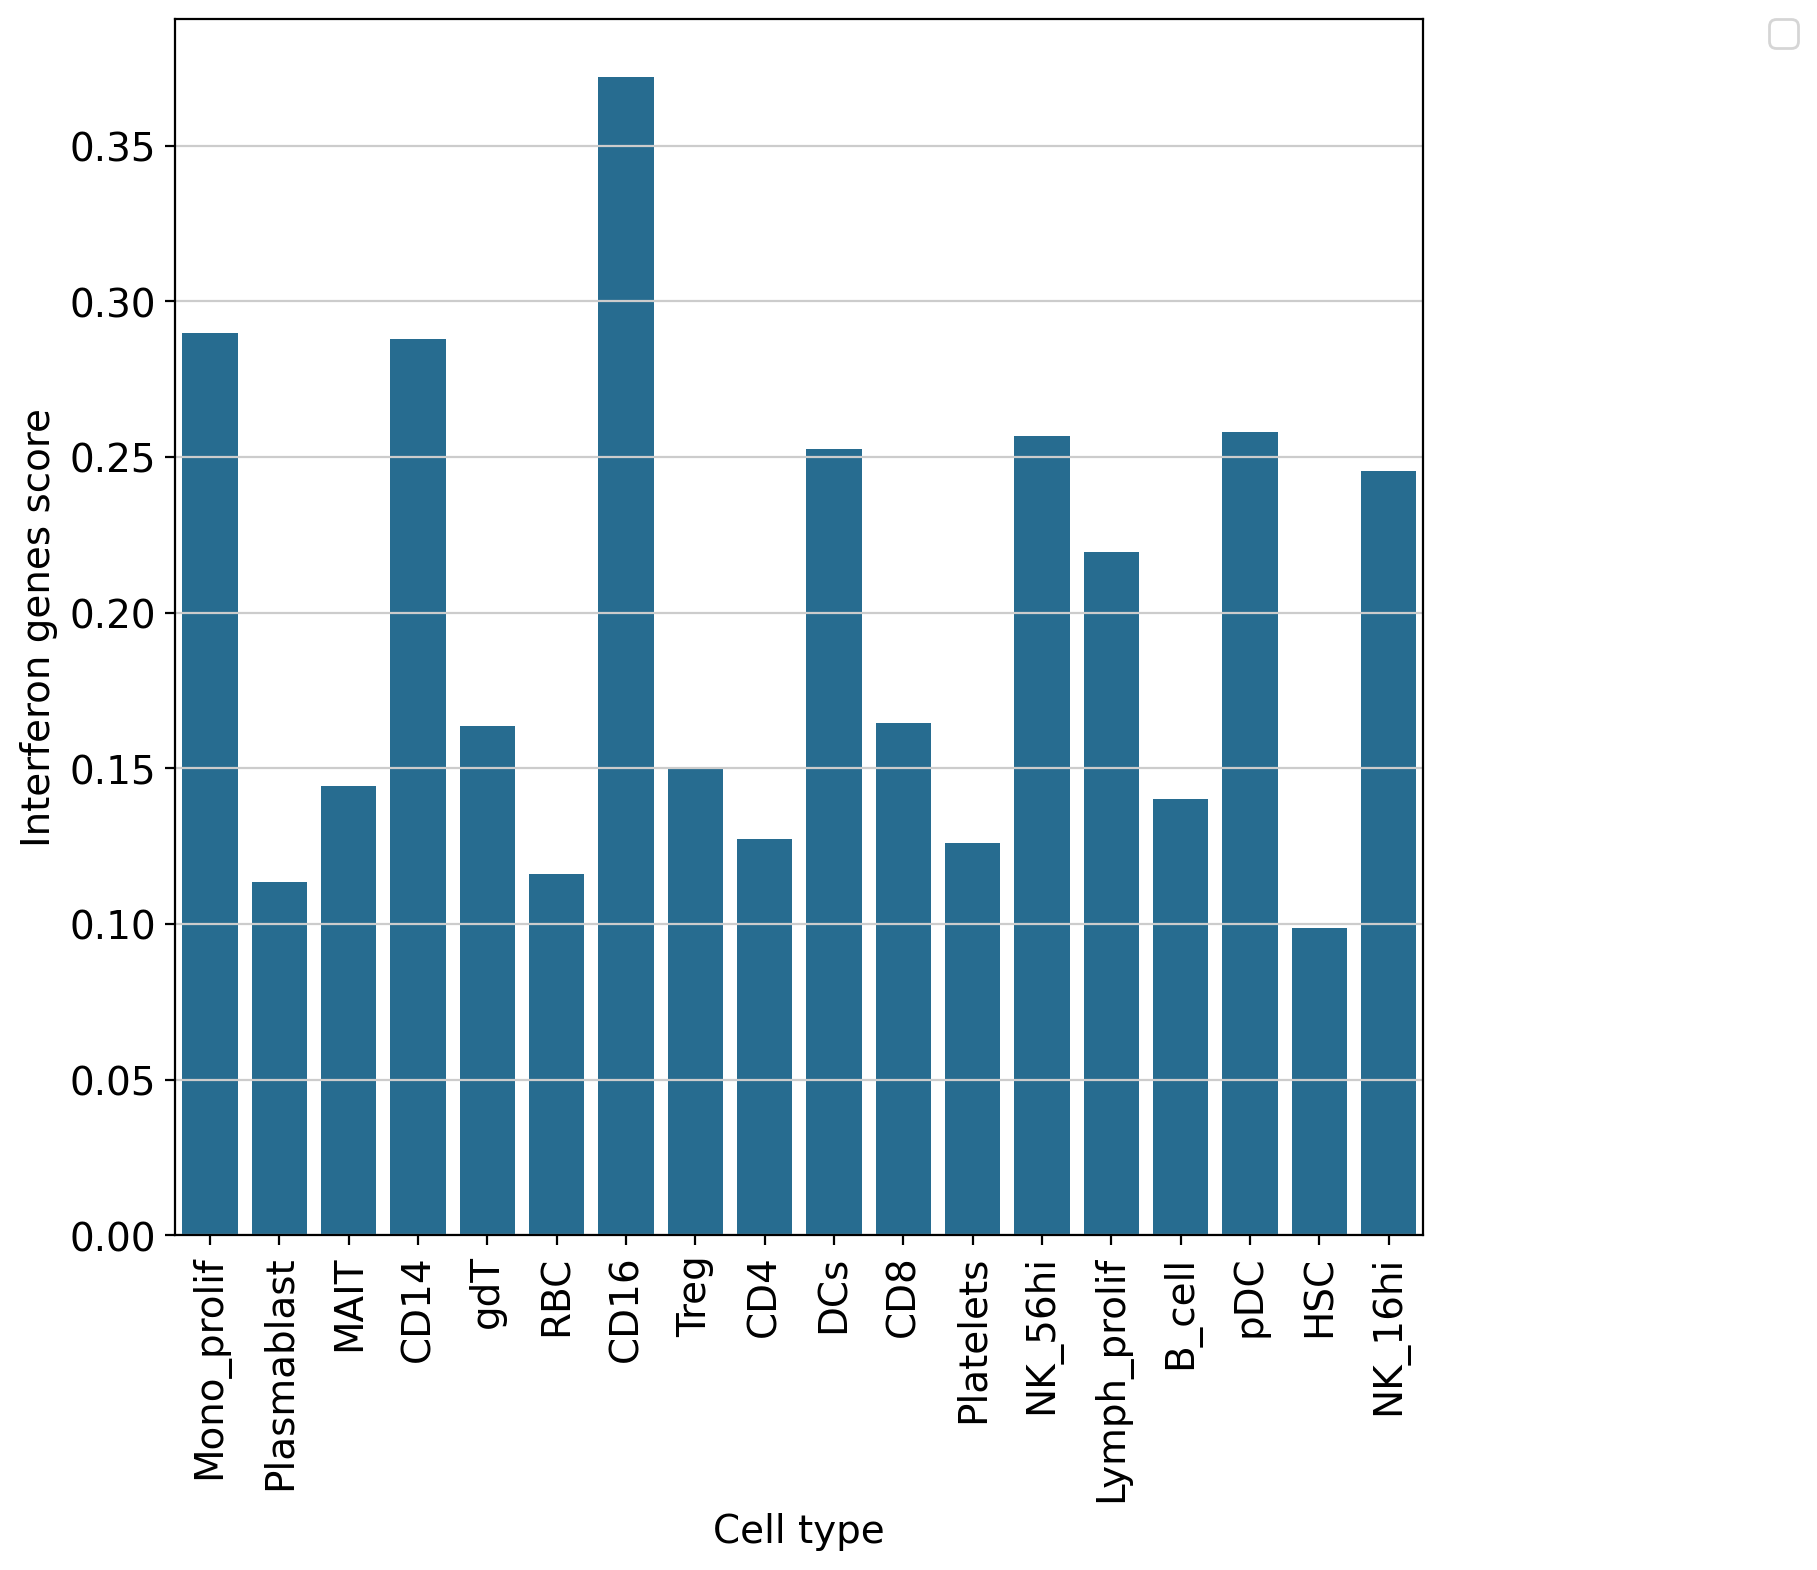

In [212]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
sns.barplot(x="initial_clustering", y="biger_list",
            data= overal,
            hue_order=order, color="#1572A1", order=list(df_mean["initial_clustering"]))
plt.ylabel("Interferon genes score")
plt.xlabel("Cell type")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0)
fig = ax.get_figure()
fig.savefig("./figures/att_hanifa_ct_lfc.pdf")

## viusalizng  scores per condition 

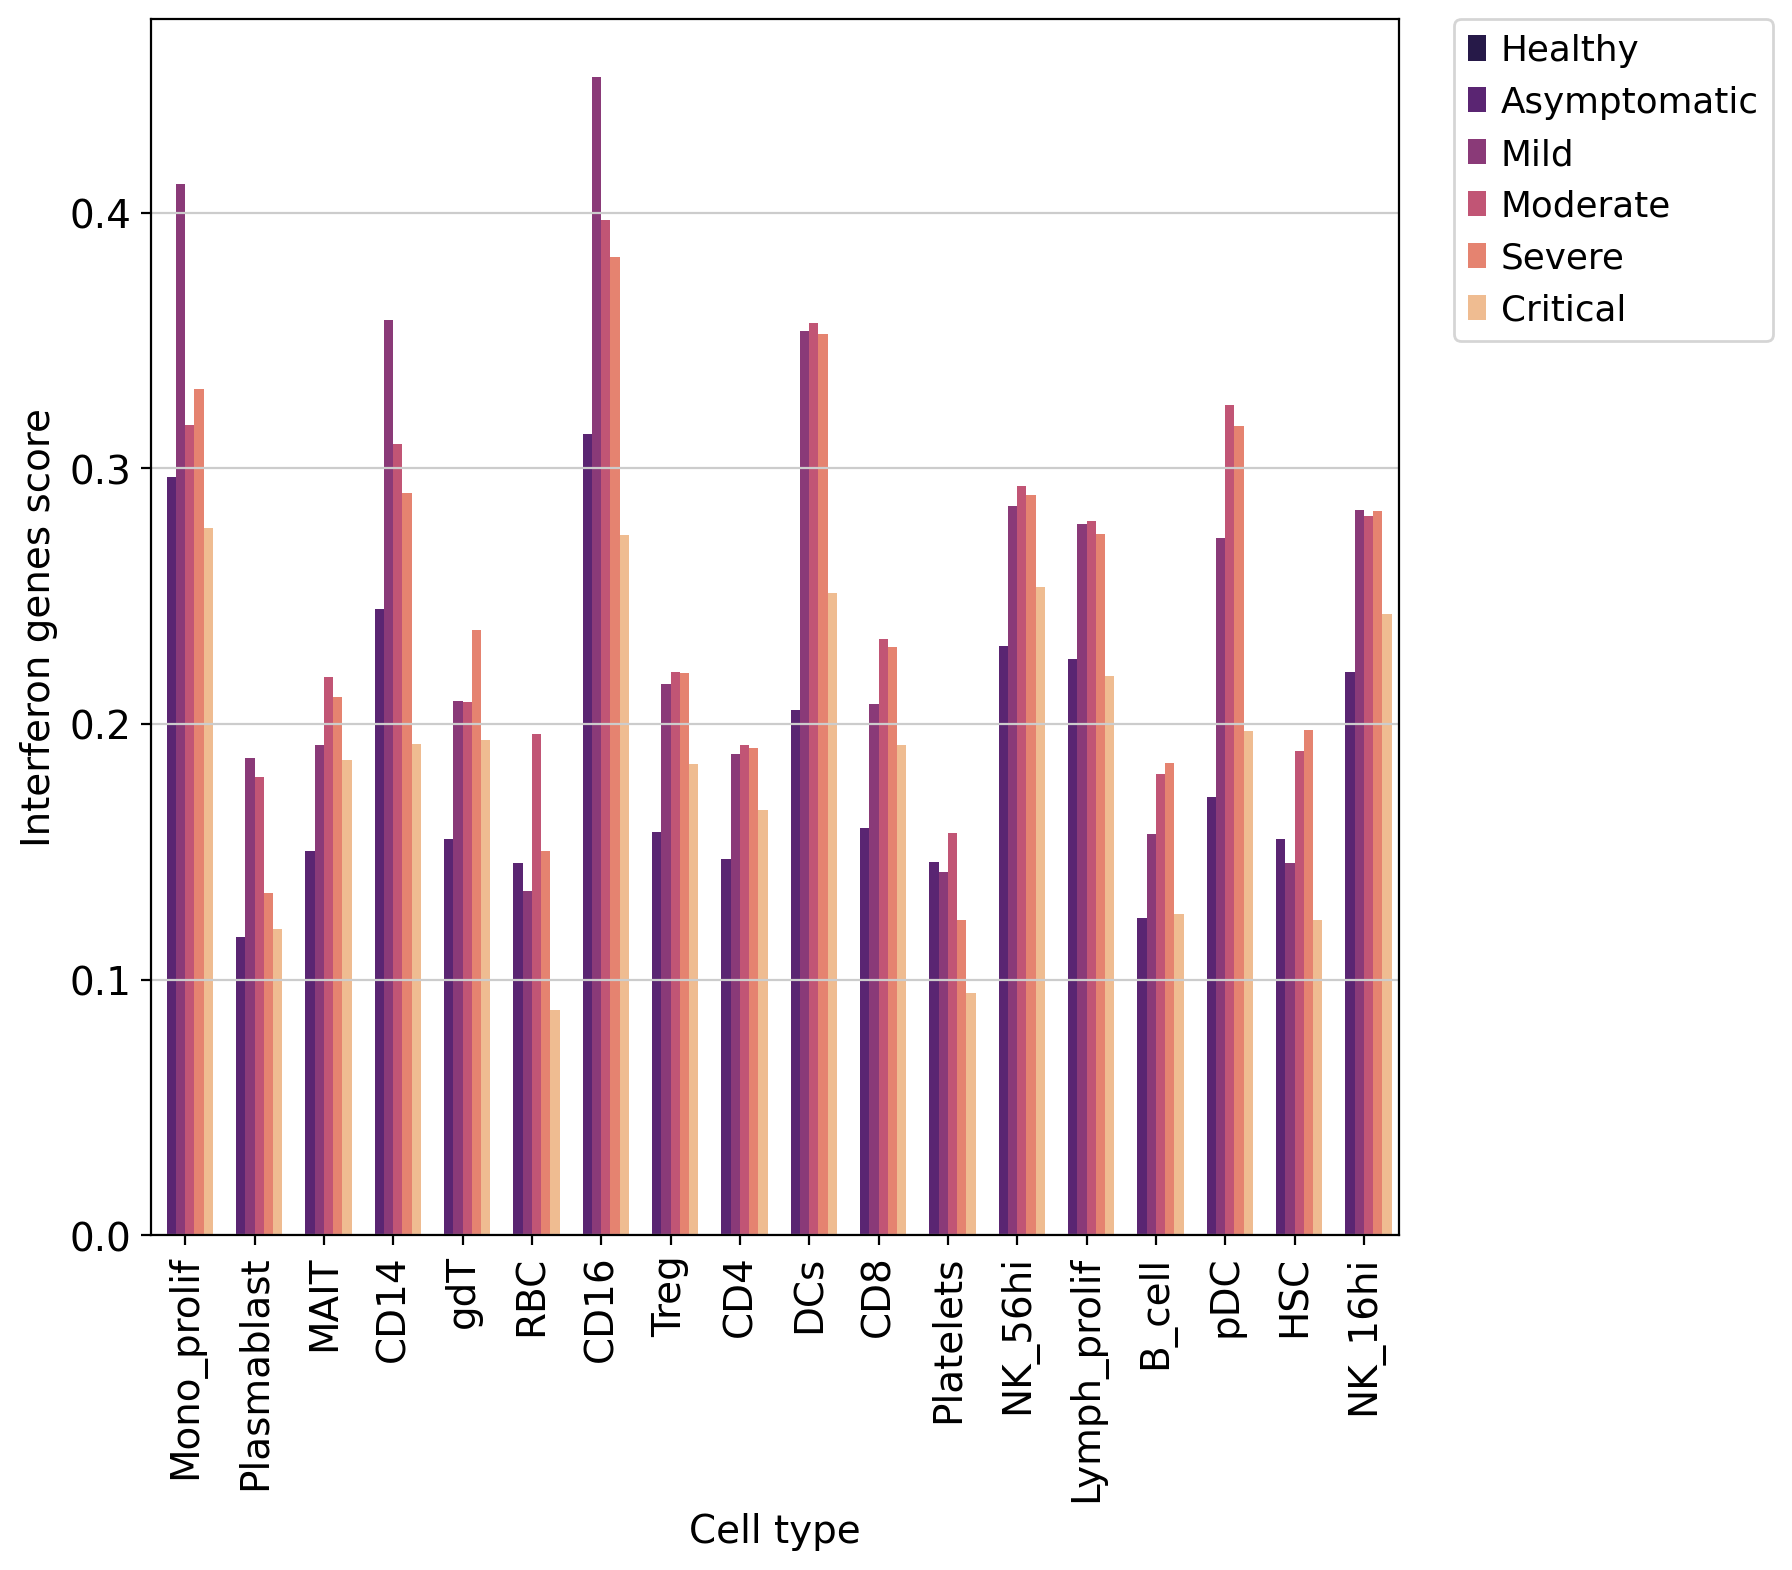

In [213]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
sns.barplot(x="initial_clustering", y="score",
            data= non_heatlhy_df, hue="Status_on_day_collection_summary",
            hue_order=order, palette="magma", order=list(df_mean["initial_clustering"]))
plt.ylabel("Interferon genes score")
plt.xlabel("Cell type")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0)
fig = ax.get_figure()
fig.savefig("./figures/att_hanifa_ct_lfc.pdf")

Scoring using  bigger list from https://www.ebi.ac.uk/QuickGO/annotations?goUsage=descendants&goUsageRelationships=is_a,part_of,occurs_in&goId=GO:0034340&taxonId=9606&taxonUsage=descendants#:~:text=1000-,Go,-243%20annotations

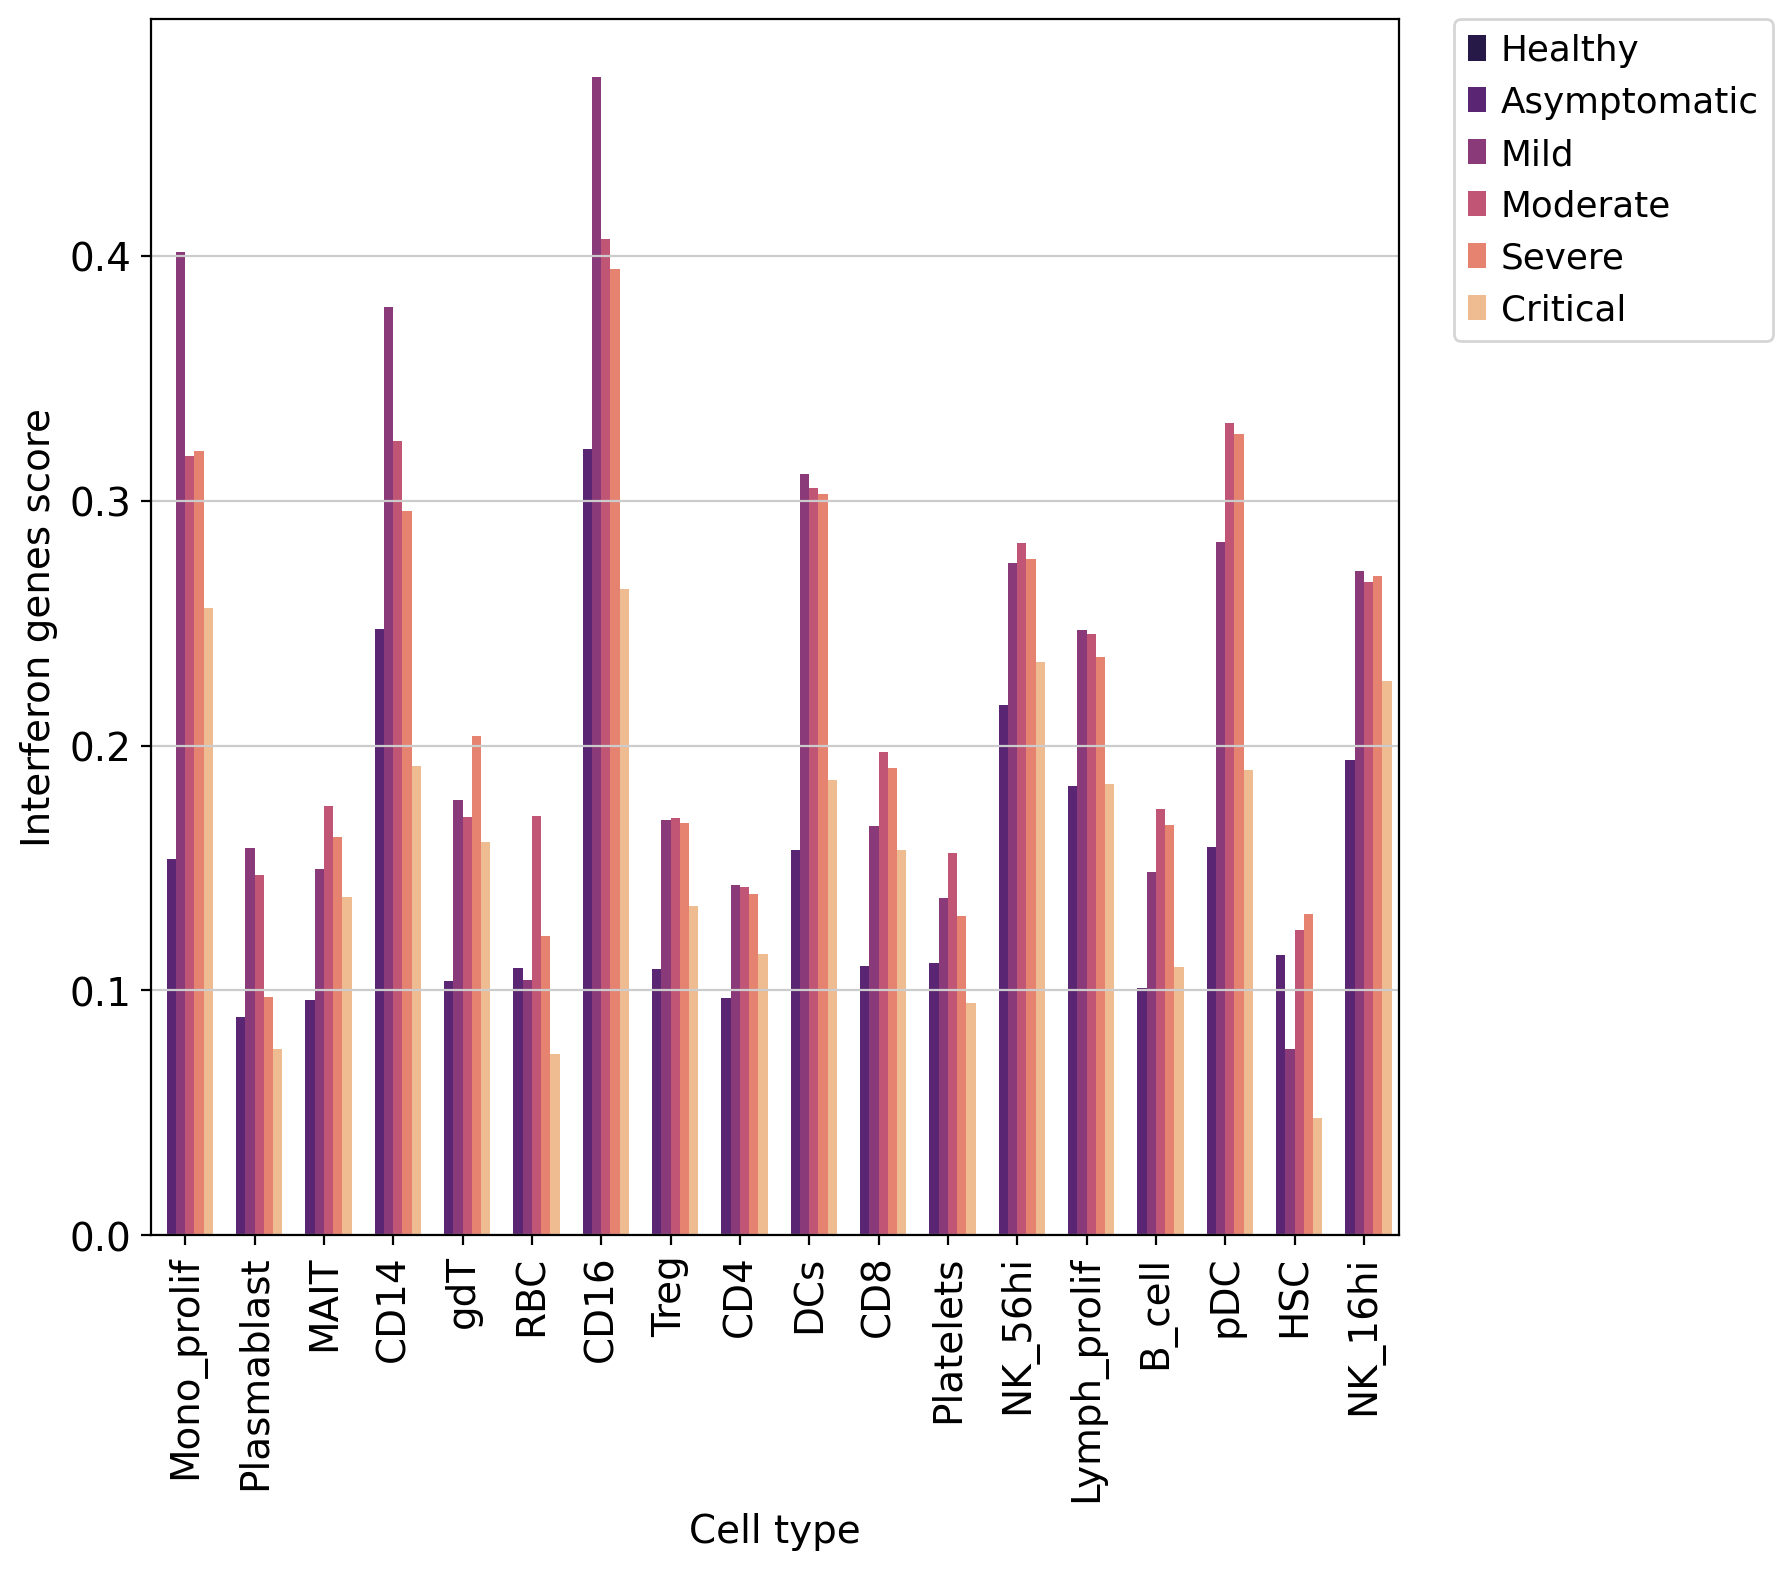

In [214]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
sns.barplot(x="initial_clustering", y="biger_list",
            data= non_heatlhy_df, hue="Status_on_day_collection_summary",
            hue_order=order, palette="magma", order=list(df_mean["initial_clustering"]))
plt.ylabel("Interferon genes score")
plt.xlabel("Cell type")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0)
fig = ax.get_figure()
fig.savefig("./figures/att_hanifa_ct_lfc.pdf")

## accounting score for healthy too

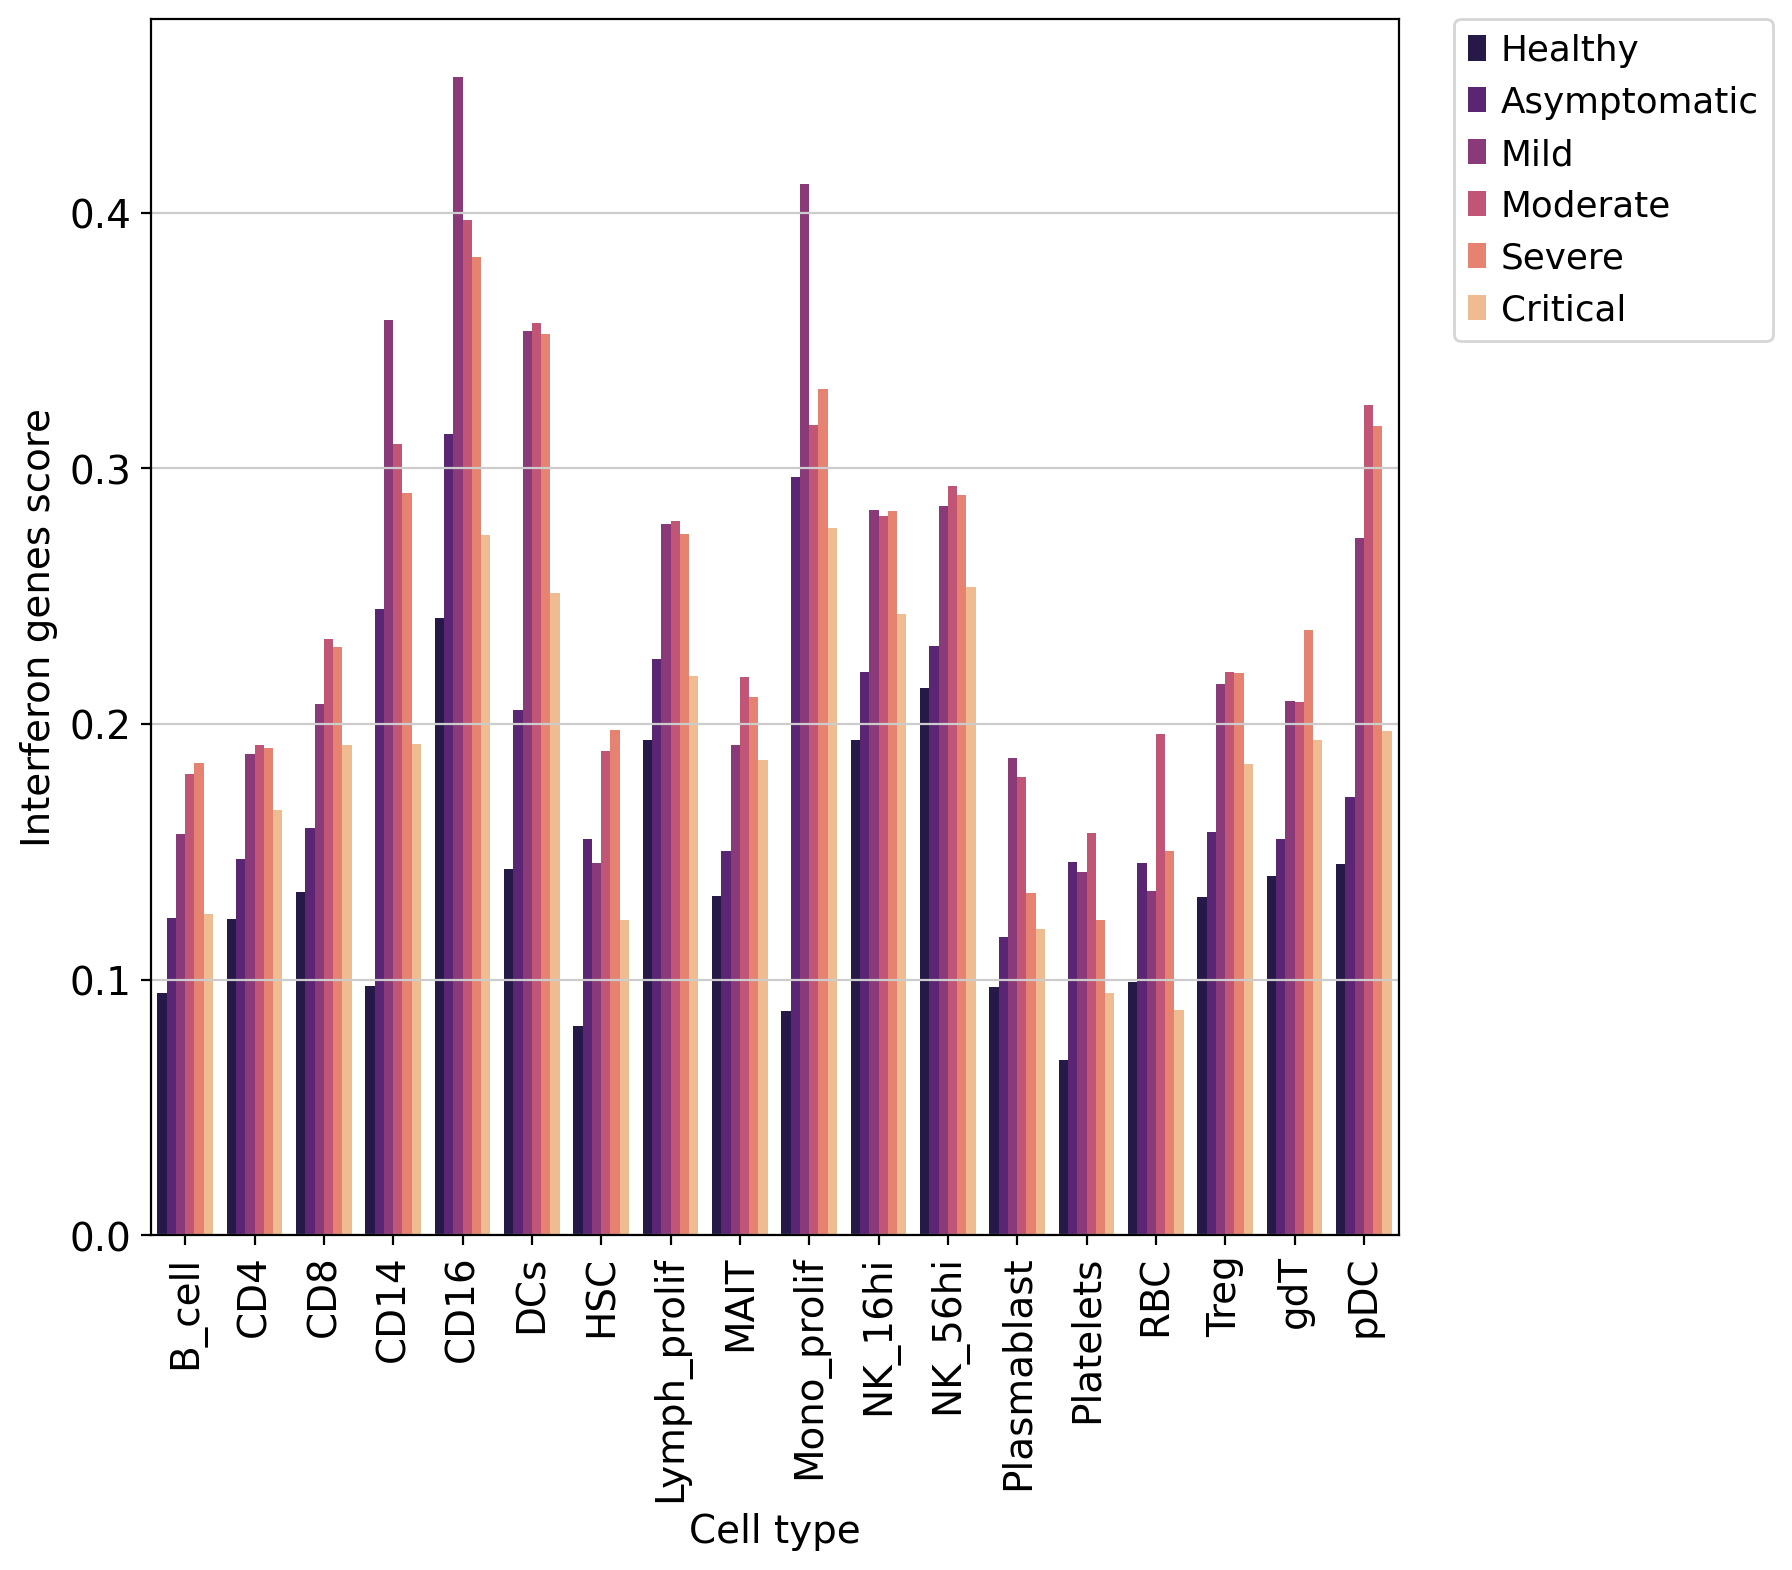

In [215]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
sns.barplot(x="initial_clustering", y="score",
            data= df_mean_full_ss, hue="Status_on_day_collection_summary",
            hue_order=order, palette="magma", )
plt.ylabel("Interferon genes score")
plt.xlabel("Cell type")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0)
fig = ax.get_figure()
fig.savefig("./figures/att_hanifa_ct_full.pdf")

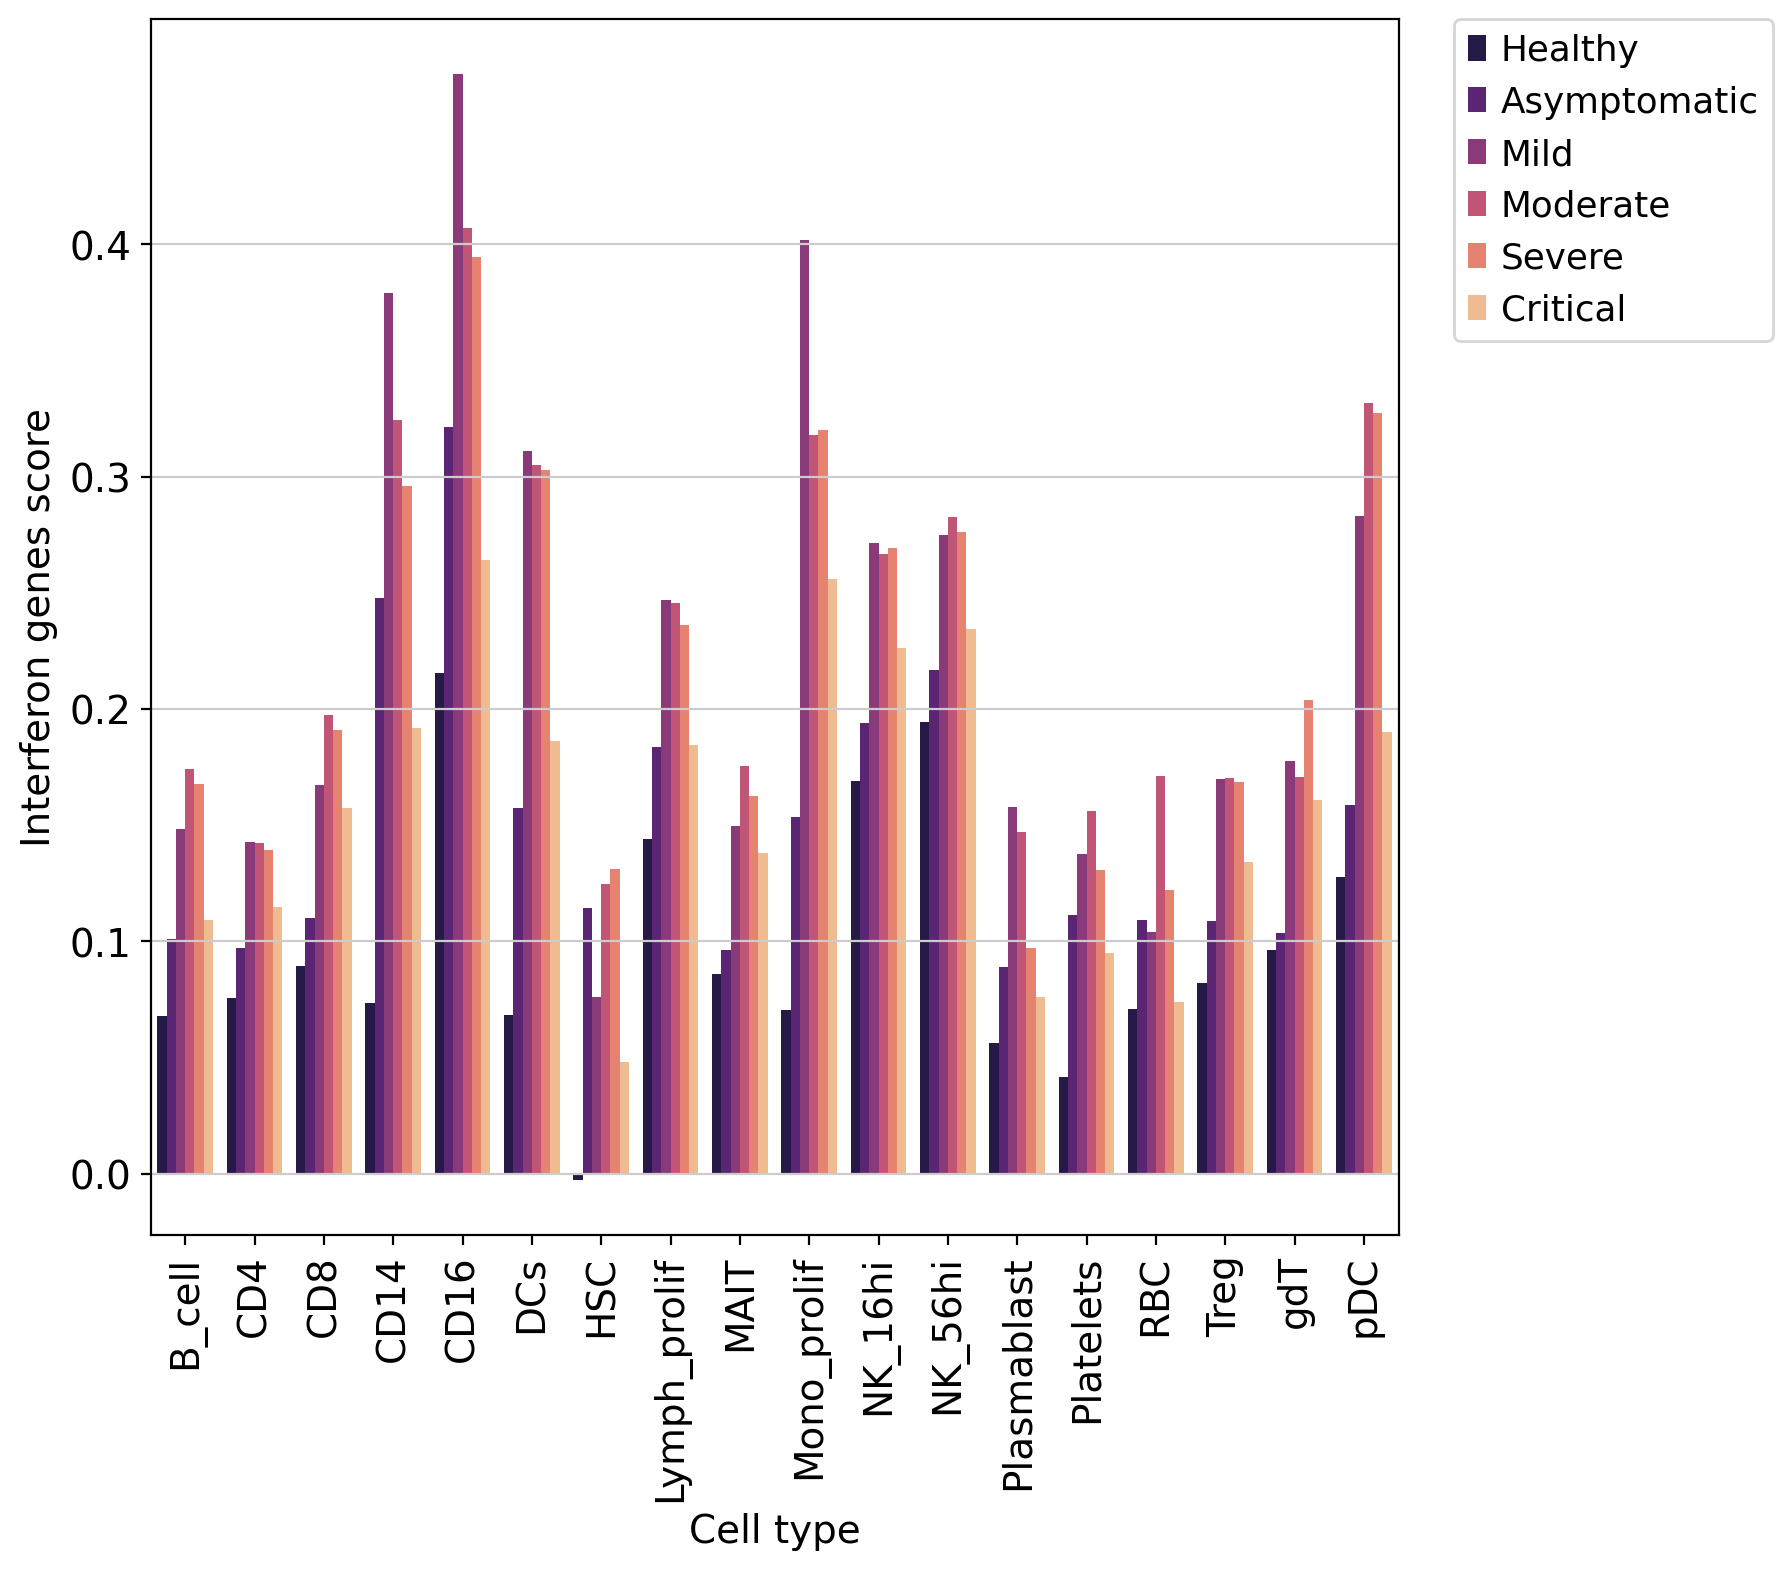

In [216]:
plt.figure(figsize = (8,8))
plt.xticks(rotation=90)
sns.barplot(x="initial_clustering", y="biger_list",
            data= df_mean_full_ss, hue="Status_on_day_collection_summary",
            hue_order=order, palette="magma", )
plt.ylabel("Interferon genes score")
plt.xlabel("Cell type")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), borderaxespad=0)
fig = ax.get_figure()
fig.savefig("./figures/att_hanifa_ct_full.pdf")

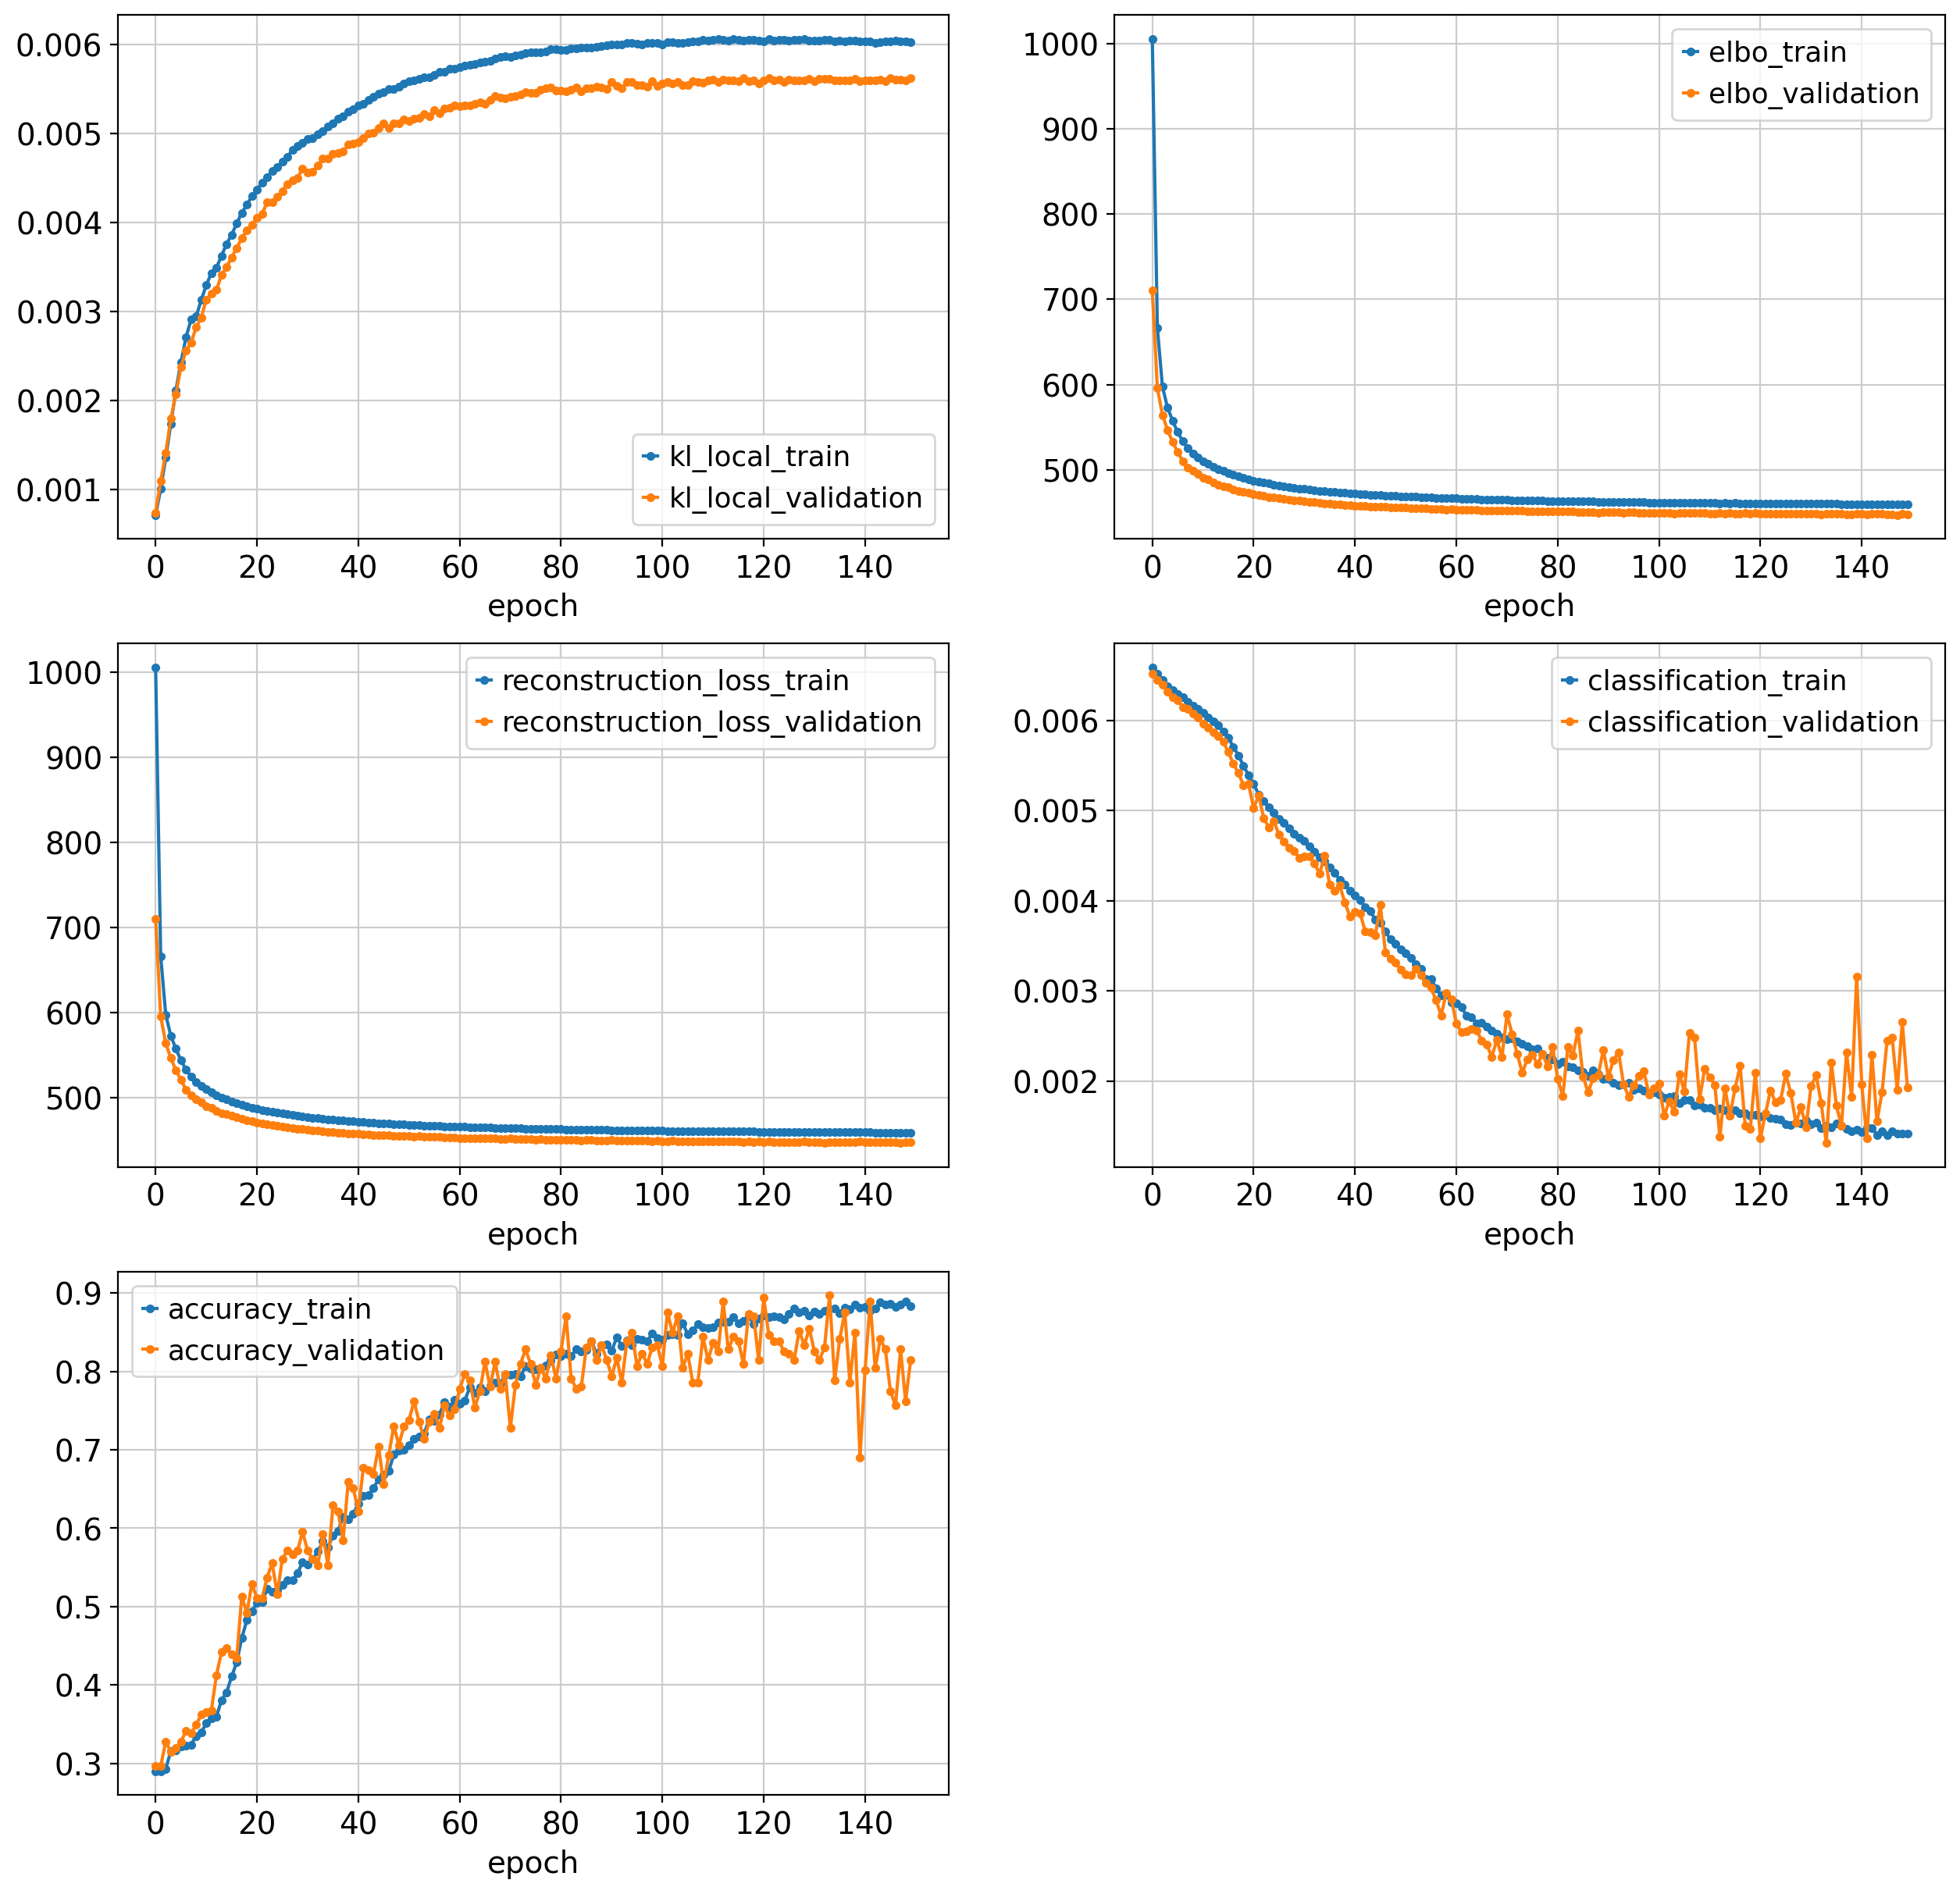

In [63]:
# df = pd.DataFrame(mil.history['train_loss_step'])
# for key in mil.history.keys():
#     if key != 'train_loss_step':
#         df = df.join(mil.history[key])

# df['epoch'] = df.index

# plt.figure(figsize=(15, 15))
# loss_names = ['kl_local', 'elbo', 'reconstruction_loss', 'classification', 'accuracy']
# nrows = 3

# for i, name in enumerate(loss_names):
#     plt.subplot(nrows, 2, i+1)
#     plt.plot(df['epoch'], df[name+'_train'], '.-', label=name+'_train')
#     plt.plot(df['epoch'], df[name+'_validation'], '.-', label=name+'_validation')
#     plt.xlabel('epoch')
#     plt.legend()